# Data Filtering and Selection

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
import sys
sys.path.append('../utils')
import functions

In [16]:
movie_df = pd.read_csv('../data/local/clean/films_19to24.csv')
movie_df.head()

,title,clean_title,original_title,genres,director,release_year,runtime,budget,revenue,popularity,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,language,tmdb_id,imdb_id
0,Gunner,gunner,Gunner,"action, thriller, crime",Dimitri Logothetis,2024,90,20000000,0,128.5,5.3,94,3.2,1845.0,English,5492,tt12598606
1,The Break-up Artist,the breakup artist,The Break-up Artist,"comedy, romance",Steve Woo,2019,105,0,0,4.5,3.5,4,4.8,1617.0,English,25356,tt1266542
2,Samurai Priest Vampire Hunter,samurai priest vampire hunter,Samurai Priest Vampire Hunter,"horror, action",Mark Terry,2023,94,0,0,10.8,3.5,2,4.0,381.0,English,28930,tt0791321
3,Mixtape,mixtape,Mixtape,"comedy, family",Valerie Weiss,2021,94,0,0,7.6,7.0,126,6.6,4292.0,English,32471,tt1587420
4,Grizzly II: Revenge,grizzly ii revenge,Grizzly II: Revenge,"horror, music, thriller",André Szöts,2020,74,7500000,0,4.1,3.0,34,2.7,1770.0,English,38258,tt0093119


### Remove Rows with Irrelevant information
- Rows with missing or incomplete data
- Rows with outliers or extreme values
- Rows with zero or negative revenue and budget
- Rows with zero or extremely low ratings
- Duplicates
- Rows with low votes
- 

In [17]:
df_cleaned = movie_df.copy()

In [18]:
# # Step 1: Remove rows with critical missing values (imdb_rating, imdb_votes, imdb_id)
# initial_row_count = len(df)
# df_cleaned = df.dropna(subset=['imdb_rating', 'imdb_votes', 'imdb_id'])
# rows_removed_step_1 = initial_row_count - len(df_cleaned)
# print(f'Rows removed after dropping rows with missing critical values: {rows_removed_step_1}')

In [19]:
# # Step 2: Remove rows with extreme z-scores for budget, revenue, or popularity
# initial_row_count = len(df_cleaned)
# df_cleaned = df_cleaned[(df_cleaned['budget_zscore'].abs() < 3) & 
#                         (df_cleaned['revenue_zscore'].abs() < 3) &
#                         (df_cleaned['popularity_zscore'].abs() < 3)]
# rows_removed_step_2 = initial_row_count - len(df_cleaned)
# print(f'Rows removed after filtering extreme z-scores: {rows_removed_step_2}')

In [20]:
# # Step 3: Remove rows with zero or negative revenue and budget
# initial_row_count = len(df_cleaned)
# df_cleaned = df_cleaned[(df_cleaned['revenue'] > 0) & (df_cleaned['budget'] > 0)]
# rows_removed_step_3 = initial_row_count - len(df_cleaned)
# print(f'Rows removed after filtering zero or negative revenue/budget: {rows_removed_step_3}')

In [21]:
# remove rows with runtime under 40 minutes
initial_row_count = len(df_cleaned)
df_cleaned = df_cleaned[df_cleaned['runtime'] > 40]
rows_removed_step_4 = initial_row_count - len(df_cleaned)
print(f'Rows removed after filtering runtime under 40 minutes: {rows_removed_step_4}')

Rows removed after filtering runtime under 40 minutes: 28019


In [22]:
# remove rows with low ratings (below a threshold of 1)
initial_row_count = len(df_cleaned)
df_cleaned = df_cleaned[df_cleaned['tmdb_rating'] > 1]
df_cleaned = df_cleaned[df_cleaned['imdb_rating'] > 1]
rows_removed_step_5 = initial_row_count - len(df_cleaned)
print(f'Rows removed after filtering low ratings: {rows_removed_step_5}')

Rows removed after filtering low ratings: 39712


In [23]:
# remove duplicates
initial_row_count = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates(subset=['tmdb_id', 'imdb_id', 'title'])
rows_removed_step_6 = initial_row_count - len(df_cleaned)
print(f'Rows removed after dropping duplicates: {rows_removed_step_6}')

Rows removed after dropping duplicates: 0


In [24]:
# remove rows with very few votes (below a threshold of 10)
initial_row_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['tmdb_votes'] >= 10) & (df_cleaned['imdb_votes'] >= 10)]
rows_removed_step_7 = initial_row_count - len(df_cleaned)
print(f'Rows removed after filtering low vote count: {rows_removed_step_7}')

Rows removed after filtering low vote count: 21259


In [25]:
# cleaned dataset
final_row_count = len(df_cleaned)
print(f'Final number of rows in the cleaned dataset: {final_row_count}')

Final number of rows in the cleaned dataset: 12884


In [26]:
df_cleaned.head()

,title,clean_title,original_title,genres,director,release_year,runtime,budget,revenue,popularity,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,language,tmdb_id,imdb_id
0,Gunner,gunner,Gunner,"action, thriller, crime",Dimitri Logothetis,2024,90,20000000,0,128.5,5.3,94,3.2,1845.0,English,5492,tt12598606
3,Mixtape,mixtape,Mixtape,"comedy, family",Valerie Weiss,2021,94,0,0,7.6,7.0,126,6.6,4292.0,English,32471,tt1587420
4,Grizzly II: Revenge,grizzly ii revenge,Grizzly II: Revenge,"horror, music, thriller",André Szöts,2020,74,7500000,0,4.1,3.0,34,2.7,1770.0,English,38258,tt0093119
6,Bad Boys for Life,bad boys for life,Bad Boys for Life,"thriller, action, crime","Bilall Fallah, Adil El Arbi",2020,124,90000000,426505244,67.7,7.1,8251,6.5,186716.0,English,38700,tt1502397
7,All Quiet on the Western Front,all quiet on the western front,Im Westen nichts Neues,"drama, war, action",Edward Berger,2022,147,20000000,0,57.8,7.7,3860,7.8,261563.0,German,49046,tt1016150


### Data Overview

#### Descriptive Stats

In [27]:
# Basic statistics for numerical columns
print("Descriptive Statistics:")
print(df_cleaned.describe())

# Get information on data types and non-null counts
print("\nData Types and Non-null Counts:")
print(df_cleaned.info())

# Check for unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
print(df_cleaned[['genres', 'director', 'language', 'release_year']].nunique())


Descriptive Statistics:
       release_year       runtime        budget       revenue    popularity  \
count  12884.000000  12884.000000  1.288400e+04  1.288400e+04  12884.000000   
mean    2021.093527    100.723688  3.820404e+06  9.589708e+06     18.599239   
std        1.616310     23.045050  2.061246e+07  7.498505e+07    131.975095   
min     2019.000000     41.000000  0.000000e+00  0.000000e+00      0.000000   
25%     2020.000000     88.000000  0.000000e+00  0.000000e+00      3.800000   
50%     2021.000000     97.000000  0.000000e+00  0.000000e+00      7.000000   
75%     2022.000000    110.000000  0.000000e+00  0.000000e+00     14.200000   
max     2024.000000    803.000000  4.600000e+08  2.799439e+09  12656.300000   

        tmdb_rating    tmdb_votes   imdb_rating    imdb_votes       tmdb_id  
count  12884.000000  12884.000000  12884.000000  1.288400e+04  1.288400e+04  
mean       6.335540    247.745576      5.886565  1.079857e+04  7.776670e+05  
std        0.936654    942.380

#### Check missing values

In [28]:
# Check for missing values
print("\nMissing Values in Columns:")
print(df_cleaned.isnull().sum())



Missing Values in Columns:
title             0
clean_title       0
original_title    0
genres            0
director          0
release_year      0
runtime           0
budget            0
revenue           0
popularity        0
tmdb_rating       0
tmdb_votes        0
imdb_rating       0
imdb_votes        0
language          0
tmdb_id           0
imdb_id           0
dtype: int64


#### Correlation Matrix

In [ ]:
# Plot correlation matrix
corr = df_cleaned.corr()

# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'Gunner'

#### Visualize Distributions

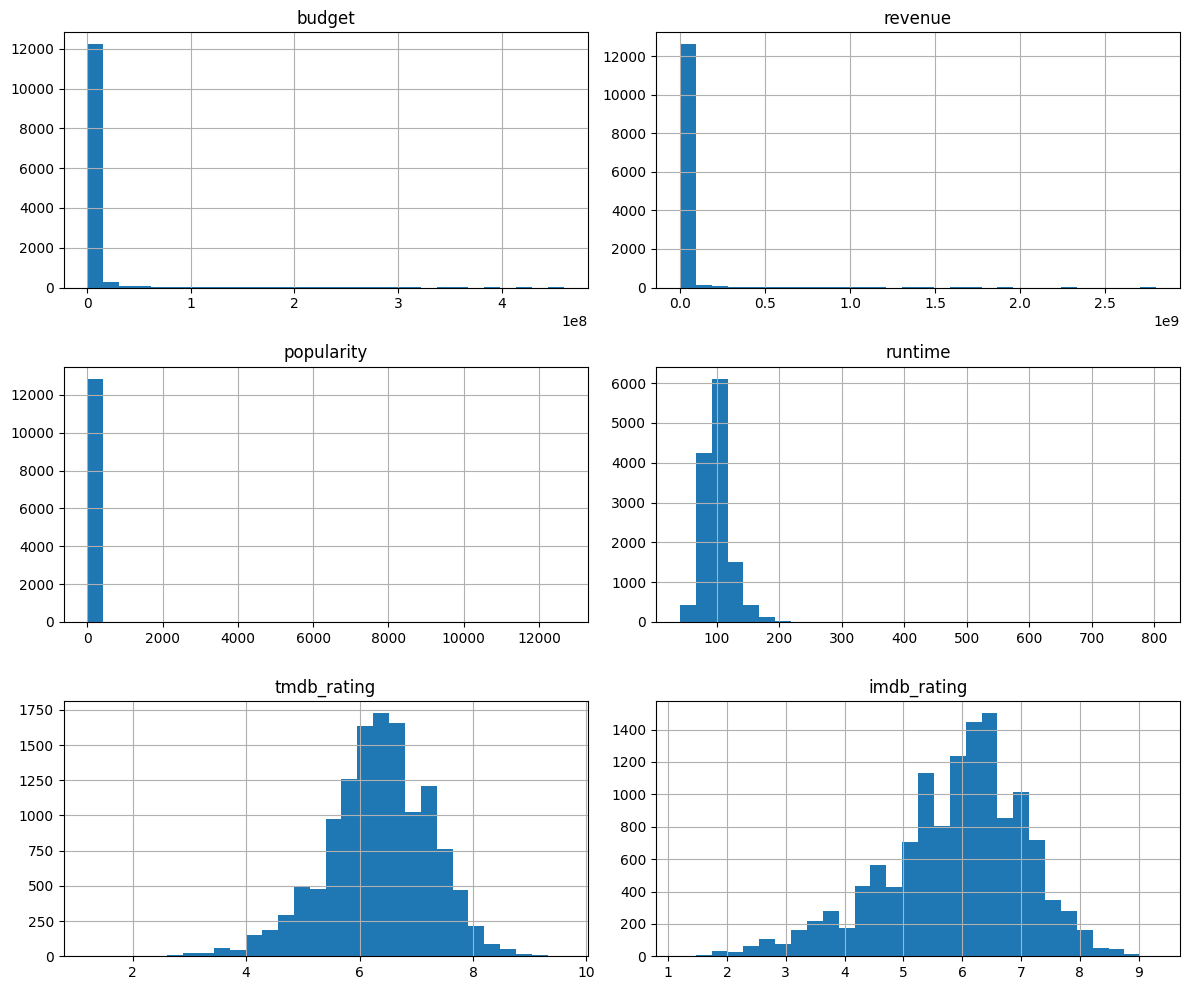

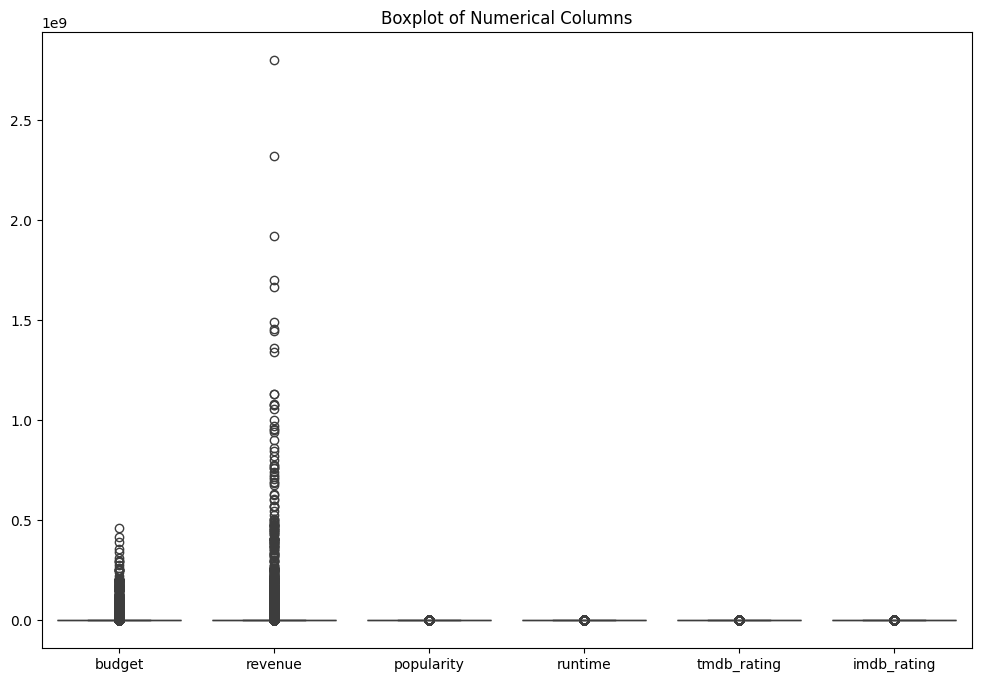

In [30]:
# Histograms for numerical columns
df_cleaned[['budget', 'revenue', 'popularity', 'runtime', 'tmdb_rating', 'imdb_rating']].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# Boxplots for better understanding of the distributions
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[['budget', 'revenue', 'popularity', 'runtime', 'tmdb_rating', 'imdb_rating']])
plt.title('Boxplot of Numerical Columns')
plt.show()

#### Trends Over Time

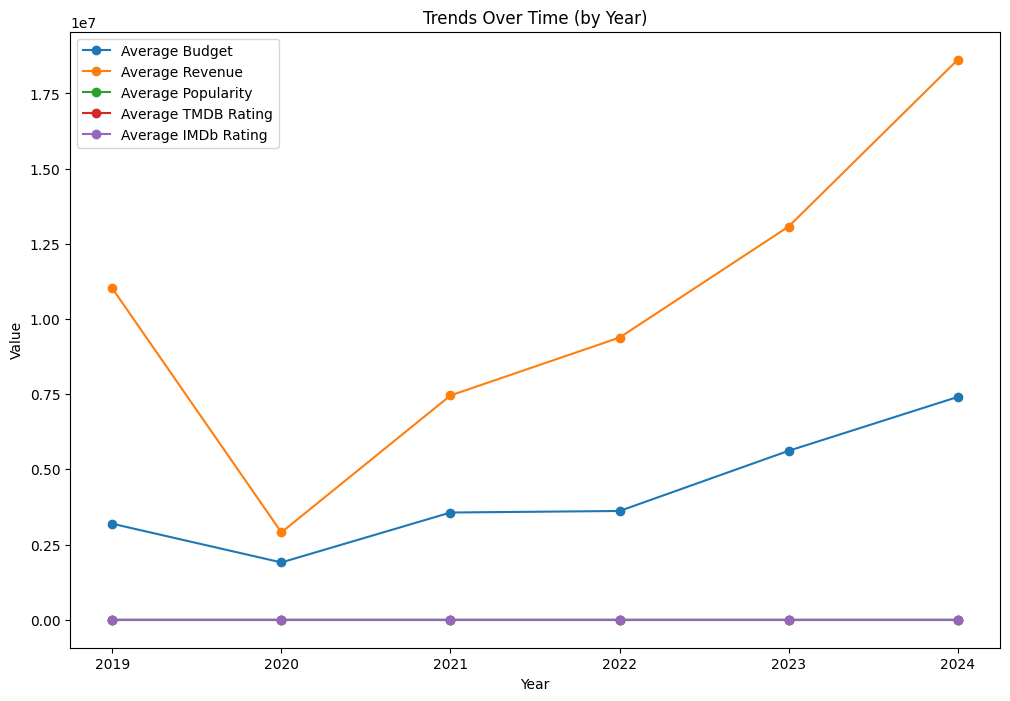

In [31]:
# Group data by release year and calculate mean values
yearly_trends = df_cleaned.groupby('release_year').agg({
    'budget': 'mean',
    'revenue': 'mean',
    'popularity': 'mean',
    'tmdb_rating': 'mean',
    'imdb_rating': 'mean',
    'runtime': 'mean'
}).reset_index()

# Plot trends over time
plt.figure(figsize=(12, 8))
plt.plot(yearly_trends['release_year'], yearly_trends['budget'], label='Average Budget', marker='o')
plt.plot(yearly_trends['release_year'], yearly_trends['revenue'], label='Average Revenue', marker='o')
plt.plot(yearly_trends['release_year'], yearly_trends['popularity'], label='Average Popularity', marker='o')
plt.plot(yearly_trends['release_year'], yearly_trends['tmdb_rating'], label='Average TMDB Rating', marker='o')
plt.plot(yearly_trends['release_year'], yearly_trends['imdb_rating'], label='Average IMDb Rating', marker='o')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Trends Over Time (by Year)')
plt.legend()
plt.show()


#### Popularity and Revenue Relationship

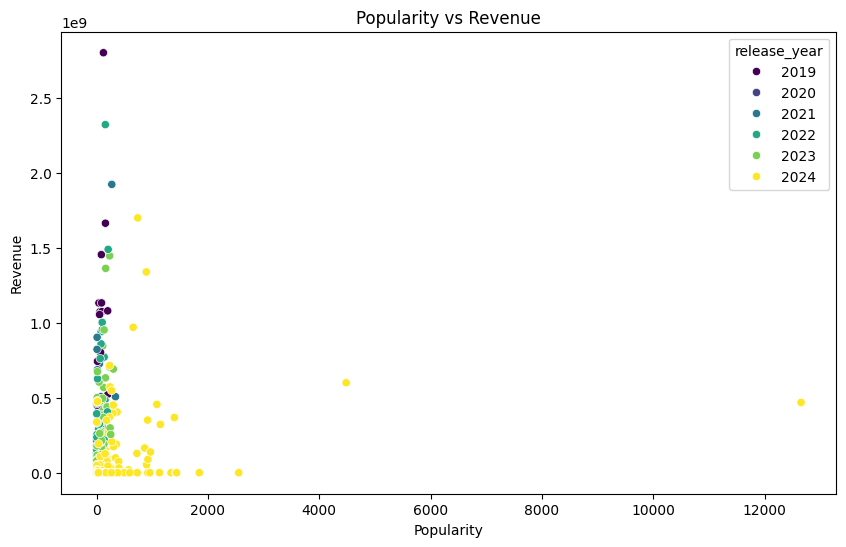

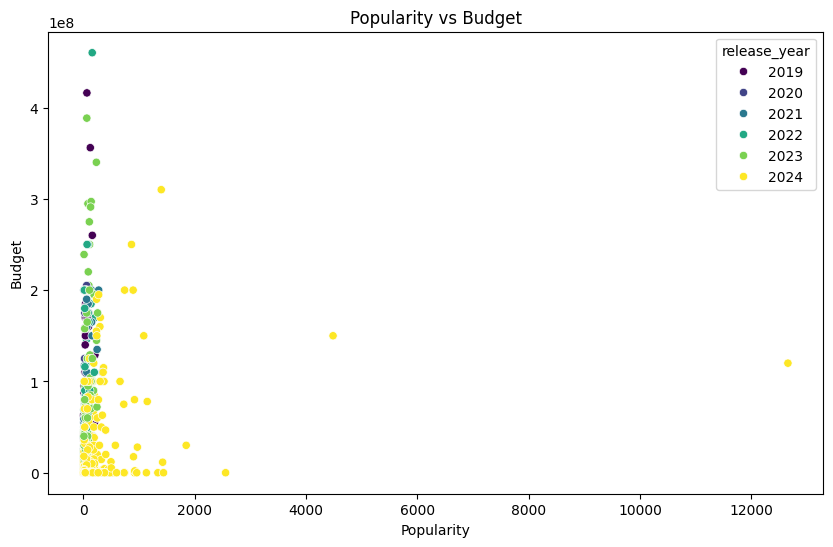

In [32]:
# Scatter plot for popularity vs revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='popularity', y='revenue', hue='release_year', palette='viridis')
plt.title('Popularity vs Revenue')
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.show()

# Scatter plot for popularity vs budget
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='popularity', y='budget', hue='release_year', palette='viridis')
plt.title('Popularity vs Budget')
plt.xlabel('Popularity')
plt.ylabel('Budget')
plt.show()


#### Rating Distribution by Genre

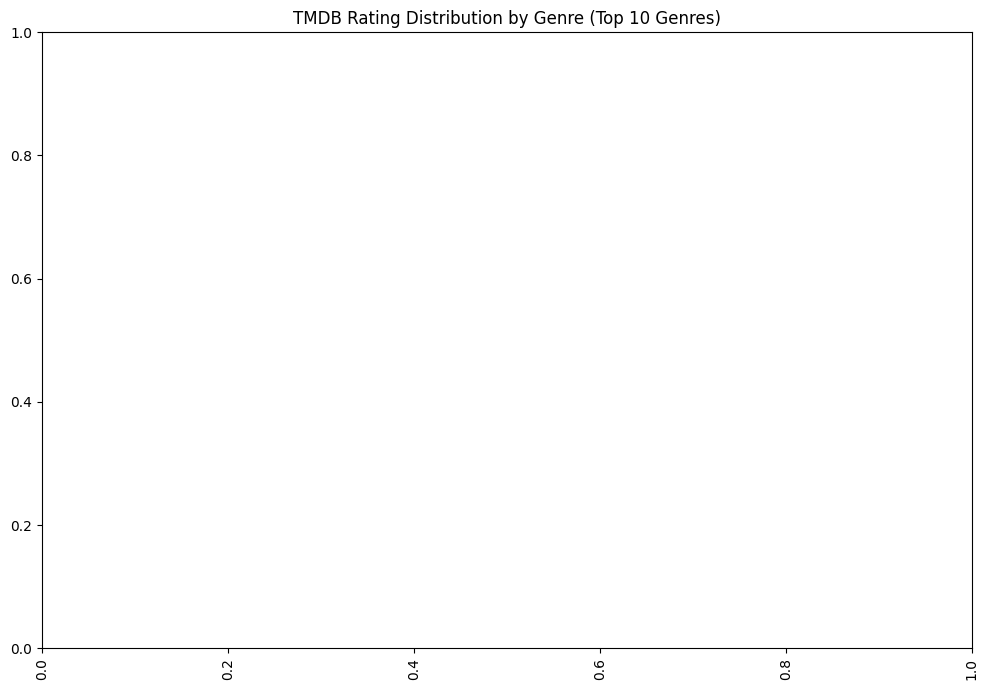

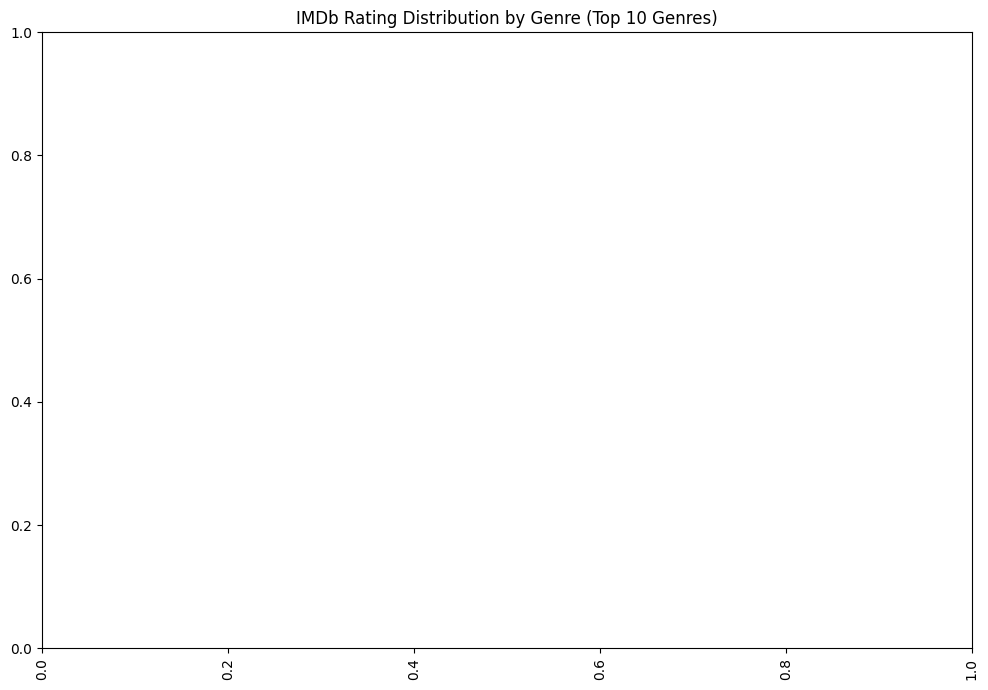

In [ ]:
# Take a 10% sample of the DataFrame for easier visualization
df_sample = df_cleaned.sample(frac=0.1, random_state=42)

# Split genres into separate rows for analysis
df_genre = df_sample[['genres', 'tmdb_rating', 'imdb_rating']].explode('genres')

# Plot TMDB Rating Distribution by Genre
plt.figure(figsize=(12, 8))
sns.boxplot(x='genres', y='tmdb_rating', data=df_genre)
plt.title('TMDB Rating Distribution by Genre (Sampled Data)')
plt.xticks(rotation=90)
plt.show()

# Plot IMDb Rating Distribution by Genre
plt.figure(figsize=(12, 8))
sns.boxplot(x='genres', y='imdb_rating', data=df_genre)
plt.title('IMDb Rating Distribution by Genre (Sampled Data)')
plt.xticks(rotation=90)
plt.show()

#### Analyze Directors


Top 10 Directors by Average Revenue:
                            director       revenue
3732                   James Cameron  2.320250e+09
4786                     Kelsey Mann  1.698452e+09
4280                     Jon Favreau  1.663000e+09
1620        Chris Buck, Jennifer Lee  1.453683e+09
764         Anthony Russo, Joe Russo  1.399947e+09
6111  Michael Jelenic, Aaron Horvath  1.362000e+09
7747          Ryan Fleck, Anna Boden  1.131416e+09
3648                     J.J. Abrams  1.074144e+09
4294                       Jon Watts  1.017925e+09
1822                 Colin Trevorrow  1.001978e+09


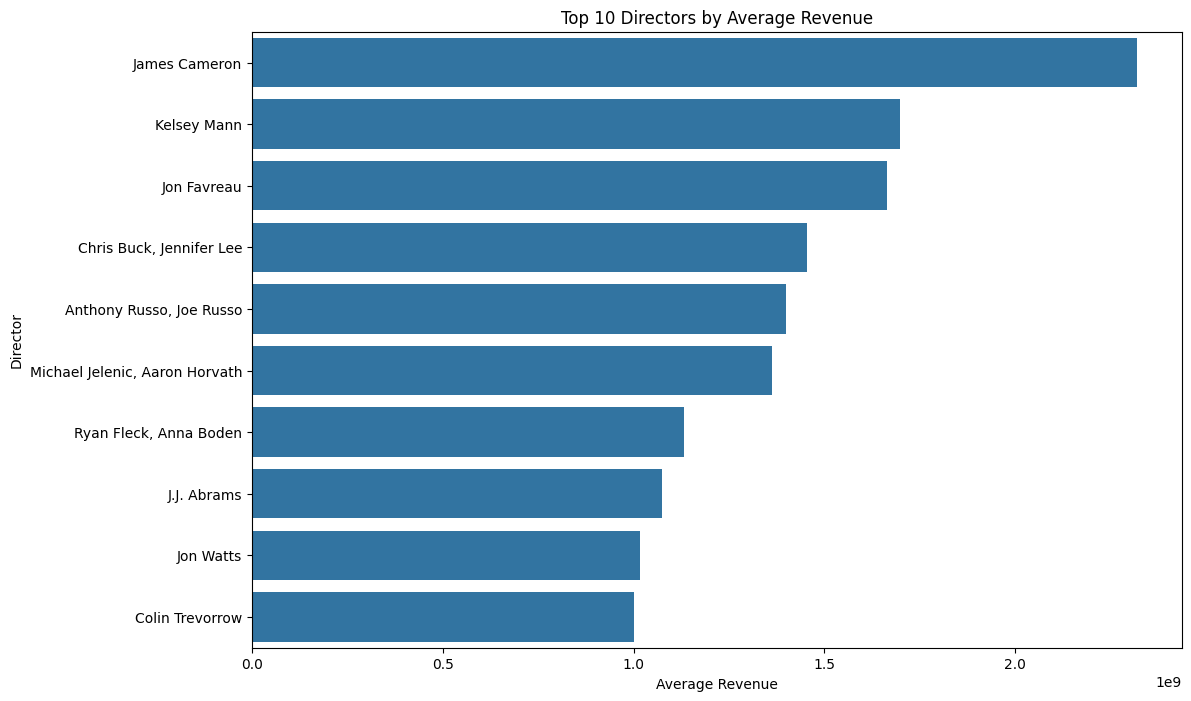

In [34]:
# Group data by director and calculate the mean for key variables
director_stats = df_cleaned.groupby('director').agg({
    'budget': 'mean',
    'revenue': 'mean',
    'popularity': 'mean',
    'tmdb_rating': 'mean',
    'imdb_rating': 'mean',
    'runtime': 'mean'
}).reset_index()

# Top directors by average revenue
top_directors = director_stats.sort_values(by='revenue', ascending=False).head(10)
print("\nTop 10 Directors by Average Revenue:")
print(top_directors[['director', 'revenue']])

# Plot the top 10 directors by average revenue
plt.figure(figsize=(12, 8))
sns.barplot(x='revenue', y='director', data=top_directors)
plt.title('Top 10 Directors by Average Revenue')
plt.xlabel('Average Revenue')
plt.ylabel('Director')
plt.show()

#### Sentiment Analysis

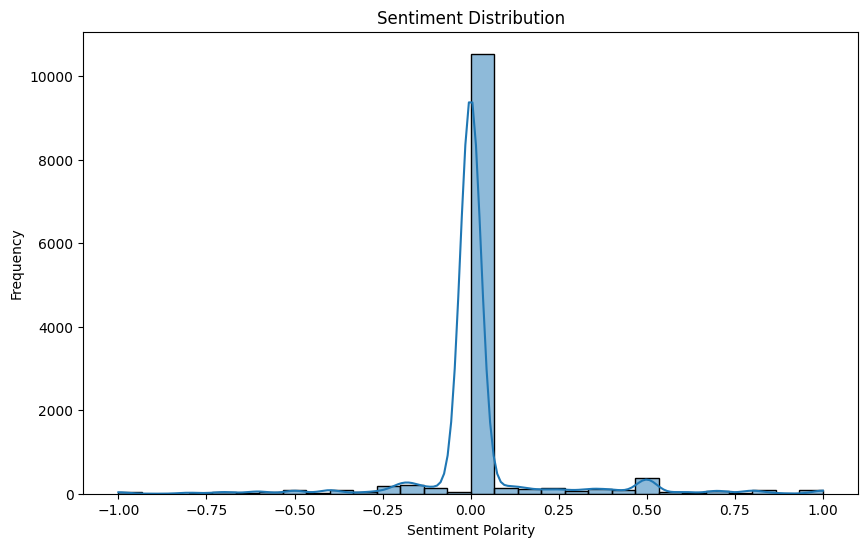

In [ ]:
# Define a function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the sentiment function to the 'title' or 'clean_title'
df_cleaned['sentiment'] = df_cleaned['title'].apply(get_sentiment)

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

Votes vs Languages

In [40]:
# Aggregate votes by language for both TMDB and IMDb
language_votes = df_cleaned.groupby('language')[['tmdb_votes', 'imdb_votes']].sum()

# Calculate the number of films per language and convert to DataFrame
language_counts = df_cleaned['language'].value_counts().to_frame(name='language_count')

# Merge the language_counts with the vote data
language_stats = language_votes.merge(language_counts, left_index=True, right_index=True)

# Calculate correlation between the votes and the number of films per language
correlation_tmdb = language_stats['tmdb_votes'].corr(language_stats['language_count'])
correlation_imdb = language_stats['imdb_votes'].corr(language_stats['language_count'])

# Print the correlations
print(f'Correlation between TMDB votes and number of films per language: {correlation_tmdb:.2f}')
print(f'Correlation between IMDb votes and number of films per language: {correlation_imdb:.2f}')


Correlation between TMDB votes and number of films per language: 0.99
Correlation between IMDb votes and number of films per language: 0.98


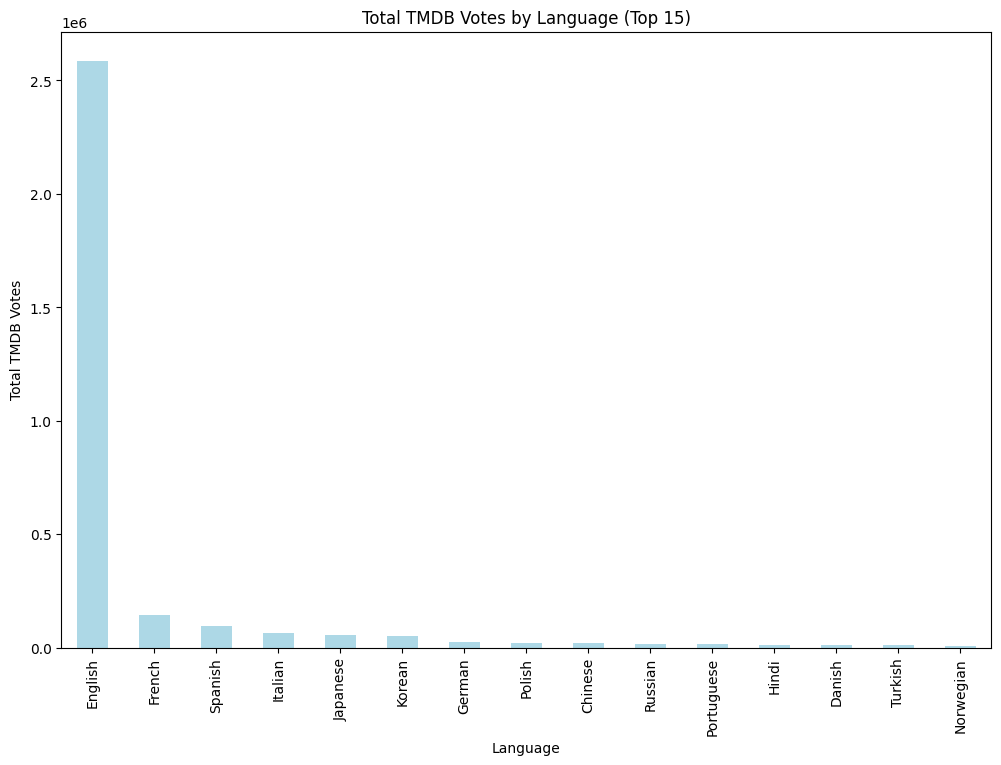

In [41]:
# Visualize the distribution of TMDB votes by language (top 15 for readability)
top_languages_tmdb = language_stats['tmdb_votes'].sort_values(ascending=False).head(15)
top_languages_tmdb.plot(kind='bar', figsize=(12, 8), color='lightblue')
plt.title('Total TMDB Votes by Language (Top 15)')
plt.xlabel('Language')
plt.ylabel('Total TMDB Votes')
plt.xticks(rotation=90)
plt.show()

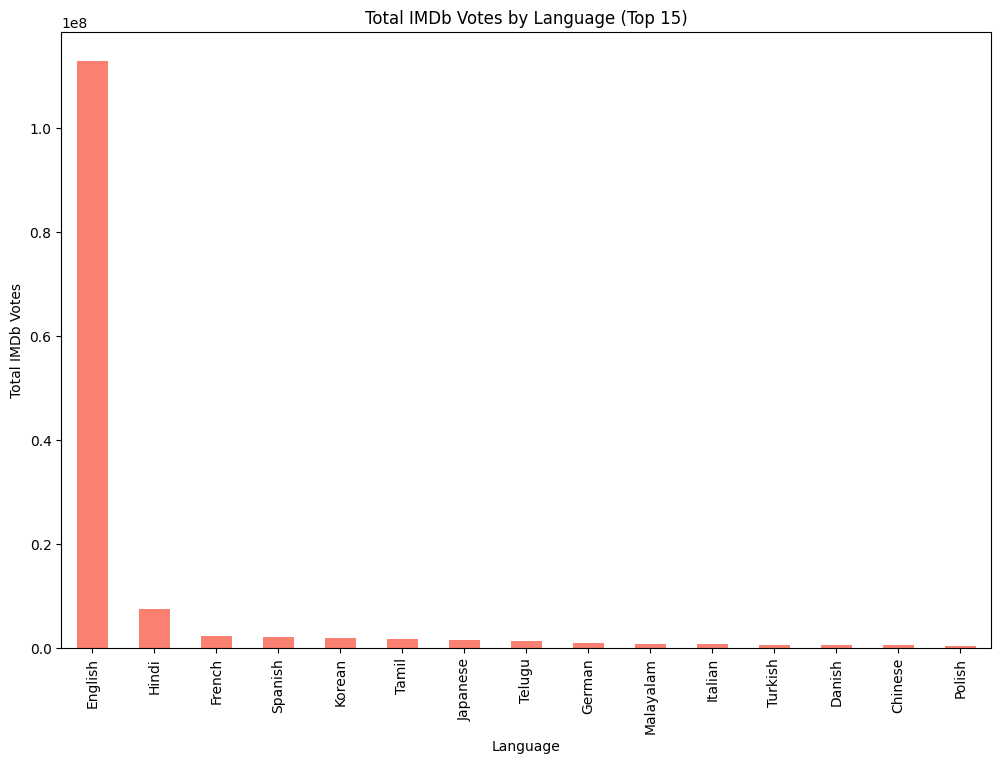

In [42]:


# Visualize the distribution of IMDb votes by language (top 15 for readability)
top_languages_imdb = language_stats['imdb_votes'].sort_values(ascending=False).head(15)
top_languages_imdb.plot(kind='bar', figsize=(12, 8), color='salmon')
plt.title('Total IMDb Votes by Language (Top 15)')
plt.xlabel('Language')
plt.ylabel('Total IMDb Votes')
plt.xticks(rotation=90)
plt.show()

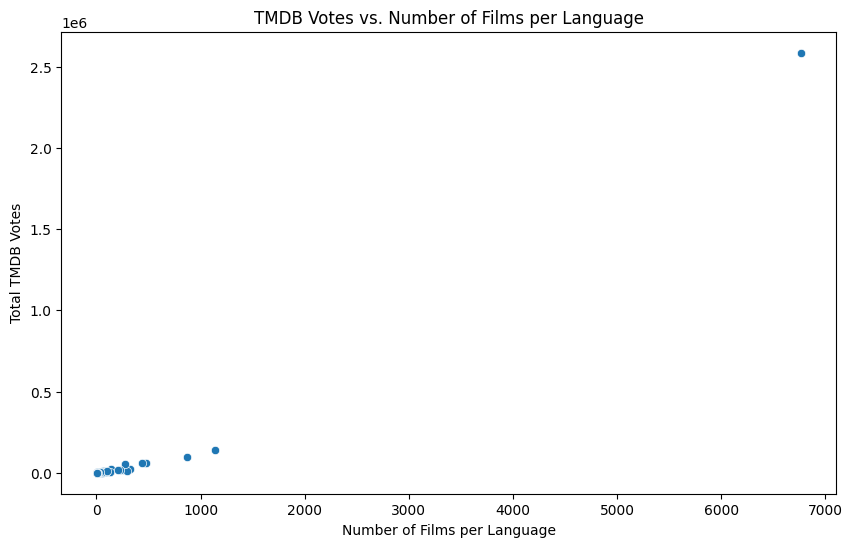

In [43]:
# Scatter plot of TMDB votes vs. number of films per language
plt.figure(figsize=(10, 6))
sns.scatterplot(x=language_stats['language_count'], y=language_stats['tmdb_votes'])
plt.title('TMDB Votes vs. Number of Films per Language')
plt.xlabel('Number of Films per Language')
plt.ylabel('Total TMDB Votes')
plt.show()

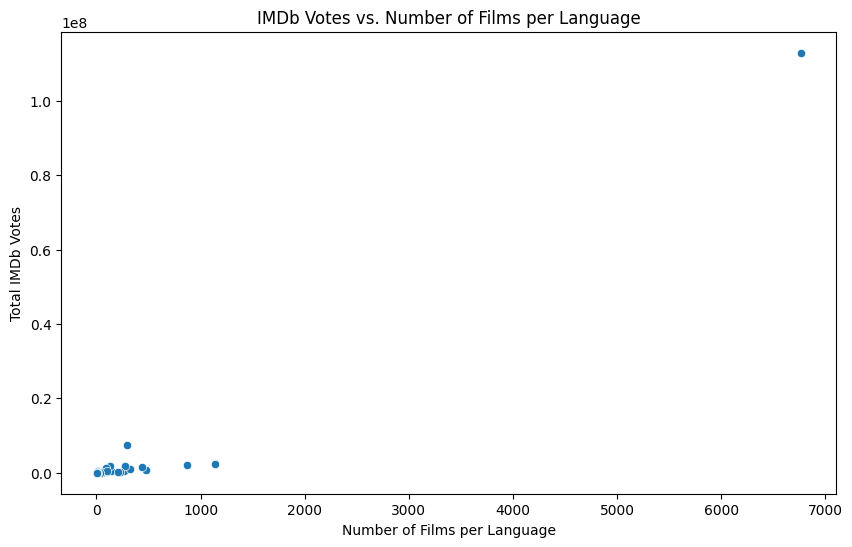

In [44]:
# Scatter plot of IMDb votes vs. number of films per language
plt.figure(figsize=(10, 6))
sns.scatterplot(x=language_stats['language_count'], y=language_stats['imdb_votes'])
plt.title('IMDb Votes vs. Number of Films per Language')
plt.xlabel('Number of Films per Language')
plt.ylabel('Total IMDb Votes')
plt.show()

Same without English

Correlation between TMDB votes and number of films per language (excluding English): 0.97
Correlation between IMDb votes and number of films per language (excluding English): 0.55


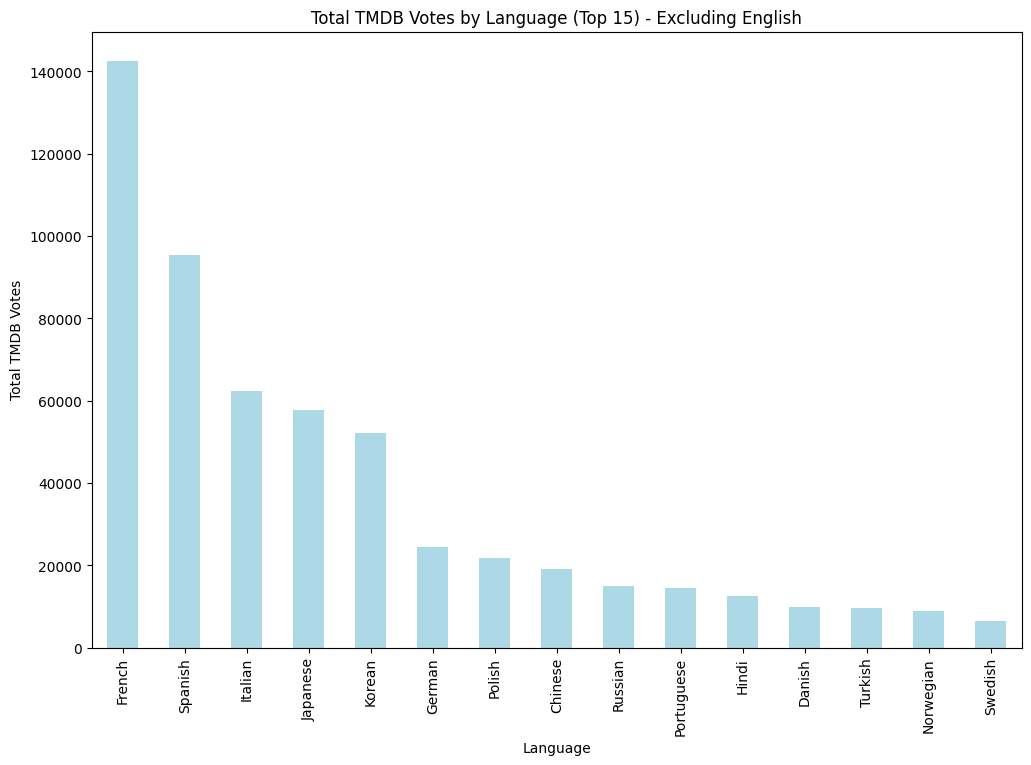

Text(0.5, 1.0, 'Total IMDb Votes by Language (Top 15) - Excluding English')

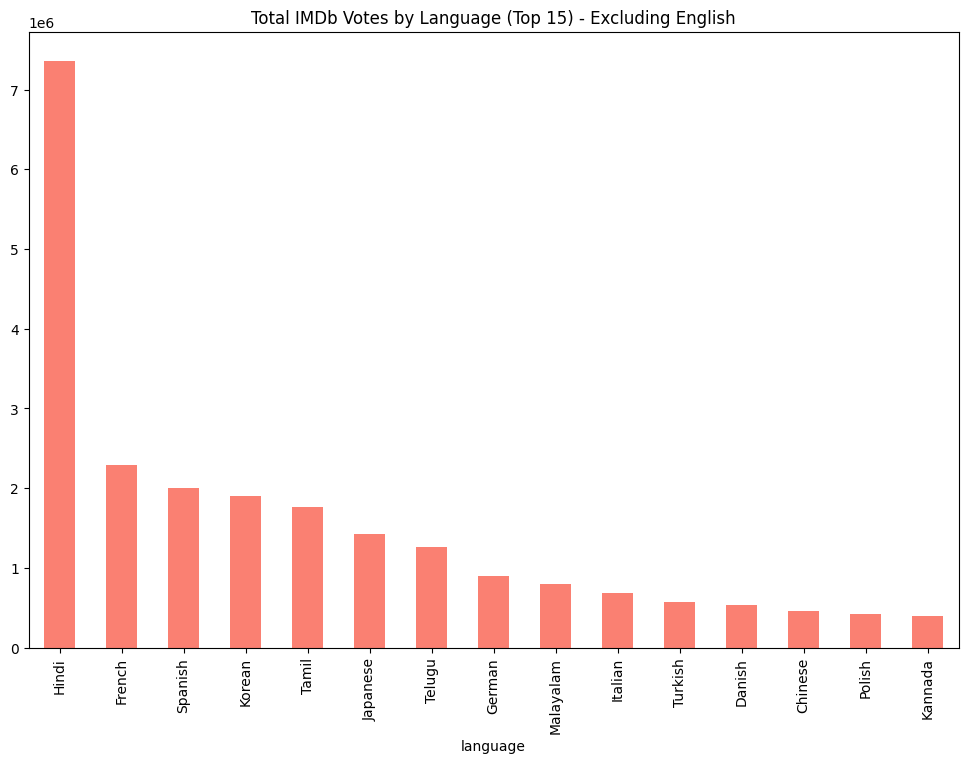

In [ ]:
# Exclude English language
df_non_english = df_cleaned[df_cleaned['language'] != 'English']

# Aggregate votes by language for both TMDB and IMDb (excluding English)
language_votes = df_non_english.groupby('language')[['tmdb_votes', 'imdb_votes']].sum()

# Calculate the number of films per language (excluding English) and convert to DataFrame
language_counts = df_non_english['language'].value_counts().to_frame(name='language_count')

# Merge the language_counts with the vote data
language_stats = language_votes.merge(language_counts, left_index=True, right_index=True)

# Calculate correlation between the votes and the number of films per language
correlation_tmdb = language_stats['tmdb_votes'].corr(language_stats['language_count'])
correlation_imdb = language_stats['imdb_votes'].corr(language_stats['language_count'])

# Print the correlations
print(f'Correlation between TMDB votes and number of films per language (excluding English): {correlation_tmdb:.2f}')
print(f'Correlation between IMDb votes and number of films per language (excluding English): {correlation_imdb:.2f}')

# Visualize the distribution of TMDB votes by language (top 15 for readability)
top_languages_tmdb = language_stats['tmdb_votes'].sort_values(ascending=False).head(15)
top_languages_tmdb.plot(kind='bar', figsize=(12, 8), color='lightblue')
plt.title('Total TMDB Votes by Language (Top 15) - Excluding English')
plt.xlabel('Language')
plt.ylabel('Total TMDB Votes')
plt.xticks(rotation=90)
plt.show()

# Visualize the distribution of IMDb votes by language (top 15 for readability)
top_languages_imdb = language_stats['imdb_votes'].sort_values(ascending=False).head(15)
top_languages_imdb.plot(kind='bar', figsize=(12, 8), color='salmon')
plt.title('Total IMDb Votes by Language (Top 15) - Excluding English')
